In [1]:
import sys, os, json, subprocess

## for data
import pandas as pd
import numpy as np
import datetime

## for machine learning
from scipy import stats
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [2]:
from kneed import KneeLocator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import sklearn.datasets
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin
from pandarallel import pandarallel
import multiprocessing

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
    
%matplotlib inline

In [4]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 7 workers


In [5]:
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [68]:
# Helper Functions
def summarize_df(df):
    for col in df.columns:
        print("#####################")
        print("Column: ", col)
        print(round(df[col].value_counts(dropna = False)/len(df),6).head(10))
        print("")
        
def classification_summary(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    print(cf)
    print('Precision: %.3f' % precision_score(y_true, y_pred))
    print('Recall: %.3f' % recall_score(y_true, y_pred))
    print('Accuracy: %.3f' % accuracy_score(y_true, y_pred))
    print('F1 Score: %.3f' % f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    
# Create Penn Color Palette
gyr = ['#011F58', '#333333', '#82AFD3', '#999999', '#CCCCCC', '#990000']
penn_palette = ListedColormap(sns.color_palette(gyr))
plt.rcParams["figure.dpi"] = 150

def bivariate_plots(feature, response, data):
    df_to_plot = pd.crosstab(data[feature], data[response], normalize = "index")
    df_to_plot.plot(kind='bar', stacked = True, figsize = (10,5),
                    title = "Response: " + response, ylabel = "Proportion",
                    width = 0.8, colormap = penn_palette).legend(loc='best')

In [6]:
pd.set_option("display.max_columns", 165)

In [6]:
data_path = "/Users/sanchit/Desktop/Data Mining/Final project/"
file_path = data_path + "HEV_article_2018.csv"

In [7]:
df = pd.read_csv(file_path)

In [9]:
df.head(10)

,Gender,Age,Education_level,All_region,All_region_recode,Employment_status,Household_members_number,Income_group,Urbanization_group,Centre_Suburbs,Driving_ability_self_evaluation,Number_vehicles_household,Plan_to_purchase_vehicle,Car_sharing_,Urban_frequent_destination_,Frequency_frequent_trip_,Passengers_last_trip,Distance_last_trip,Connection_experience_,LDT1,LDT2,LDT3,Leisure_trips_number,Multimodal_experience_evaluation_,ICT_application_use_1_,ICT_application_use_2_,ICT_application_use_3_,frequency_webpage_flight_checkin,ICT_application_use_5_,frequency_smartphone_flight_checkin,ICT_application_use_7_,ICT_application_use_8_,ICT_application_use_9_,ICT_application_use_10_,Teleworking,Online_shopping,Country,Vehicles_per_household_member,buy_electric,Mode_frequent_trip_T1_1,Mode_frequent_trip_T1_2,Mode_frequent_trip_T1_3,Mode_frequent_trip_T1_4,Mode_frequent_trip_T1_5,Mode_frequent_trip_T1_6,Mode_frequent_trip_T1_7,Mode_frequent_trip_T1_8,Mode_frequent_trip_T1_9,Mode_frequent_trip_T1_10,Mode_frequent_trip_T1_11,Mode_frequent_trip_T1_12,Travel_time_frequent_trip,Speed_frequent_trip,Passengers_per_household_member,Ratio_trip_work_leisure,Urban_centre,MLE_region,MLE_country,av_speed_region,av_speed_country,av_time_region,av_time_country,av_distance_region,av_distance_country,av_vehicles_region,av_vehicles_country,teleworking1_region,teleworking1_country,teleworking2_region,teleworking2_country,online1_region,online1_country,online2_region,online2_country,urbanization1_region,urbanization1_country,urbanization2_region,urbanization2_country,urbanization3_region,urbanization3_country,urbanization4_region,urbanization4_country,urbanization_region_likelihood,MLE_country_urb,av_speed_region_urb,av_speed_country_urb,av_time_region_urb,av_time_country_urb,av_distance_region_urb,av_distance_country_urb,av_vehicles_region_urb,av_vehicles_country_urb,income_region_likelihood,MLE_country_inc,av_speed_region_inc,av_speed_country_inc,av_time_region_inc,av_time_country_inc,av_distance_region_inc,av_distance_country_inc,av_vehicles_region_inc,av_vehicles_country_inc,education_region_likelihood,MLE_country_edu,av_speed_region_edu,av_speed_country_edu,av_time_region_edu,av_time_country_edu,av_distance_region_edu,av_distance_country_edu,av_vehicles_region_edu,av_vehicles_country_edu,centre_suburbs_region_likelihood,MLE_country_cen,av_speed_region_cen,av_speed_country_cen,av_time_region_cen,av_time_country_cen,av_distance_region_cen,av_distance_country_cen,av_vehicles_region_cen,av_vehicles_country_cen,online_shopping_region_likelihood,MLE_country_onl,av_speed_region_onl,av_speed_country_onl,av_time_region_onl,av_time_country_onl,av_distance_region_onl,av_distance_country_onl,av_vehicles_region_onl,av_vehicles_country_onl,telework_region_likelihood,MLE_country_tel,av_speed_region_tel,av_speed_country_tel,av_time_region_tel,av_time_country_tel,av_distance_region_tel,av_distance_country_tel,av_vehicles_region_tel,av_vehicles_country_tel,gender_region_likelihood,MLE_country_gen,av_speed_region_gen,av_speed_country_gen,av_time_region_gen,av_time_country_gen,av_distance_region_gen,av_distance_country_gen,av_vehicles_region_gen,av_vehicles_country_gen,age_region_likelihood,MLE_country_age,av_speed_region_age,av_speed_country_age,av_time_region_age,av_time_country_age,av_distance_region_age,av_distance_country_age,av_vehicles_region_age,av_vehicles_country_age,count_region,online_x_telework,online_shopping_region_likelihoodxtel
0,1,59,1,3,2,5,2,4,1,1,1,1,4,1,1,3,2,3,2,0,0,30,38,0,3,3,5,5,5,5,4,4,4,4,5,5,1,0.500000,0,0,0,0,1,0,0,0,0,1,0,0,0,20.0,9.000000,1.0,0.789474,11,0.534247,0.480432,6.121276,9.062626,37.547945,30.71525,3.212329,3.663968,0.569977,0.704656,0.054795,0.067476,0.102740,0.087719,0.321918,0.358974,0.383562,0.377868,0.952055,0.194332,0.047945,0.067476,0.000000,0.296896,0.000000,0.441296,0.546763,0.534722,6.140094,6.204674,37.870504,37.215278,3.237410,3.208333,0.578777,0.588773,0.521739,0.486486,6.561710,9.687855,32.565217,27.244595,3.086957,3

## Dropped Unnessecary columns 

In [8]:
cols=np.array(range(0,56))
df=df.iloc[:,cols]

# Explanatory Data Analysis

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Gender,17870.0,1.489871,0.499911,1.000000,1.000000,1.0,2.000000,2.0
Age,17870.0,40.535255,11.894582,16.000000,30.000000,41.0,49.000000,65.0
Education_level,17870.0,3.324566,0.731804,1.000000,3.000000,3.0,4.000000,4.0
All_region,17870.0,167.240627,115.360829,1.000000,65.000000,162.0,241.000000,579.0
All_region_recode,17870.0,87.554337,52.225007,1.000000,42.000000,88.0,135.000000,179.0
Employment_status,17870.0,1.832121,1.493515,1.000000,1.000000,1.0,2.000000,7.0
Household_members_number,17870.0,2.839899,1.229157,1.000000,2.000000,3.0,4.000000,7.0
Income_group,17870.0,3.236821,0.905204,1.000000,3.000000,3.0,4.000000,6.0
Urbanization_group,17870.0,2.811416,0.946627,1.000000,2.000000,3.0,3.000000,4.0
Centre_Suburbs,17870.0,1.158030,0.790059,0.000000,1.000000,1.0,2.000000,2.0


In [104]:
df.columns

Index(['Gender', 'Age', 'Education_level', 'All_region', 'All_region_recode',
       'Employment_status', 'Household_members_number', 'Income_group',
       'Urbanization_group', 'Centre_Suburbs',
       'Driving_ability_self_evaluation', 'Number_vehicles_household',
       'Plan_to_purchase_vehicle', 'Car_sharing_',
       'Urban_frequent_destination_', 'Frequency_frequent_trip_',
       'Passengers_last_trip', 'Distance_last_trip', 'Connection_experience_',
       'LDT1', 'LDT2', 'LDT3', 'Leisure_trips_number',
       'Multimodal_experience_evaluation_', 'ICT_application_use_1_',
       'ICT_application_use_2_', 'ICT_application_use_3_',
       'frequency_webpage_flight_checkin', 'ICT_application_use_5_',
       'frequency_smartphone_flight_checkin', 'ICT_application_use_7_',
       'ICT_application_use_8_', 'ICT_application_use_9_',
       'ICT_application_use_10_', 'Teleworking', 'Online_shopping', 'Country',
       'Vehicles_per_household_member', 'buy_electric',
       'Mode_freq

In [9]:
df['Age_bin'] = pd.qcut(df['Age'], 4, labels=["child", "teen", "adult", "Senior"])
df

,Gender,Age,Education_level,All_region,All_region_recode,Employment_status,Household_members_number,Income_group,Urbanization_group,Centre_Suburbs,...,Mode_frequent_trip_T1_9,Mode_frequent_trip_T1_10,Mode_frequent_trip_T1_11,Mode_frequent_trip_T1_12,Travel_time_frequent_trip,Speed_frequent_trip,Passengers_per_household_member,Ratio_trip_work_leisure,Urban_centre,Age_bin
0,1,59,1,3,2,5,2,4,1,1,...,1,0,0,0,20.0,9.000000,1.00,0.789474,11,Senior
1,1,45,1,2,1,1,2,3,4,0,...,0,0,0,0,30.0,10.000000,0.50,1.000000,40,adult
2,1,62,2,6,4,5,3,3,3,2,...,0,1,0,0,15.0,4.000000,0.00,2.000000,32,Senior
3,1,21,3,3,2,4,3,5,1,1,...,0,0,0,0,40.0,3.000000,0.00,0.000000,11,child
4,2,54,2,3,2,1,1,4,1,2,...,0,0,0,0,15.0,12.000000,1.00,1.000000,12,Senior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17865,2,50,4,576,176,1,2,3,3,2,...,0,0,0,0,35.0,10.285714,0.50,0.000000,32,Senior
17866,1,43,4,576,176,1,4,3,4,0,...,0,0,0,0,10.0,18.000000,1.00,0.000000,40,adult
17867,2,46,3,576,176,2,4,3,4,0,...,0,0,0,0,20.0,12.000000,0.25,0.000000,40,adult
17868,1,47,3,576,176,1,4,3,4,0,...,0,0,0,0,40.0,9.000000,0.25,0.000000,40,adult


* *Response Variable - buy_electric - If you had to purchase a new car, would you consider to purchase a hybrid or electric car?*


In [12]:
df.buy_electric.value_counts()

0    10658
1     7212
Name: buy_electric, dtype: int64

In [13]:
df.Plan_to_purchase_vehicle.value_counts()

4    7118
3    5061
2    2387
5    1710
1    1594
Name: Plan_to_purchase_vehicle, dtype: int64

In [14]:
numeric_cols=['Age','Leisure_trips_number','Number_vehicles_household','Frequency_frequent_trip_','Passengers_last_trip','Vehicles_per_household_member','LDT3']
categorical_cols = [col for col in df.columns if col not in numeric_cols]
categorical_cols

['Gender',
 'Education_level',
 'All_region',
 'All_region_recode',
 'Employment_status',
 'Household_members_number',
 'Income_group',
 'Urbanization_group',
 'Centre_Suburbs',
 'Driving_ability_self_evaluation',
 'Plan_to_purchase_vehicle',
 'Car_sharing_',
 'Urban_frequent_destination_',
 'Distance_last_trip',
 'Connection_experience_',
 'LDT1',
 'LDT2',
 'Multimodal_experience_evaluation_',
 'ICT_application_use_1_',
 'ICT_application_use_2_',
 'ICT_application_use_3_',
 'frequency_webpage_flight_checkin',
 'ICT_application_use_5_',
 'frequency_smartphone_flight_checkin',
 'ICT_application_use_7_',
 'ICT_application_use_8_',
 'ICT_application_use_9_',
 'ICT_application_use_10_',
 'Teleworking',
 'Online_shopping',
 'Country',
 'buy_electric',
 'Mode_frequent_trip_T1_1',
 'Mode_frequent_trip_T1_2',
 'Mode_frequent_trip_T1_3',
 'Mode_frequent_trip_T1_4',
 'Mode_frequent_trip_T1_5',
 'Mode_frequent_trip_T1_6',
 'Mode_frequent_trip_T1_7',
 'Mode_frequent_trip_T1_8',
 'Mode_frequent_tri

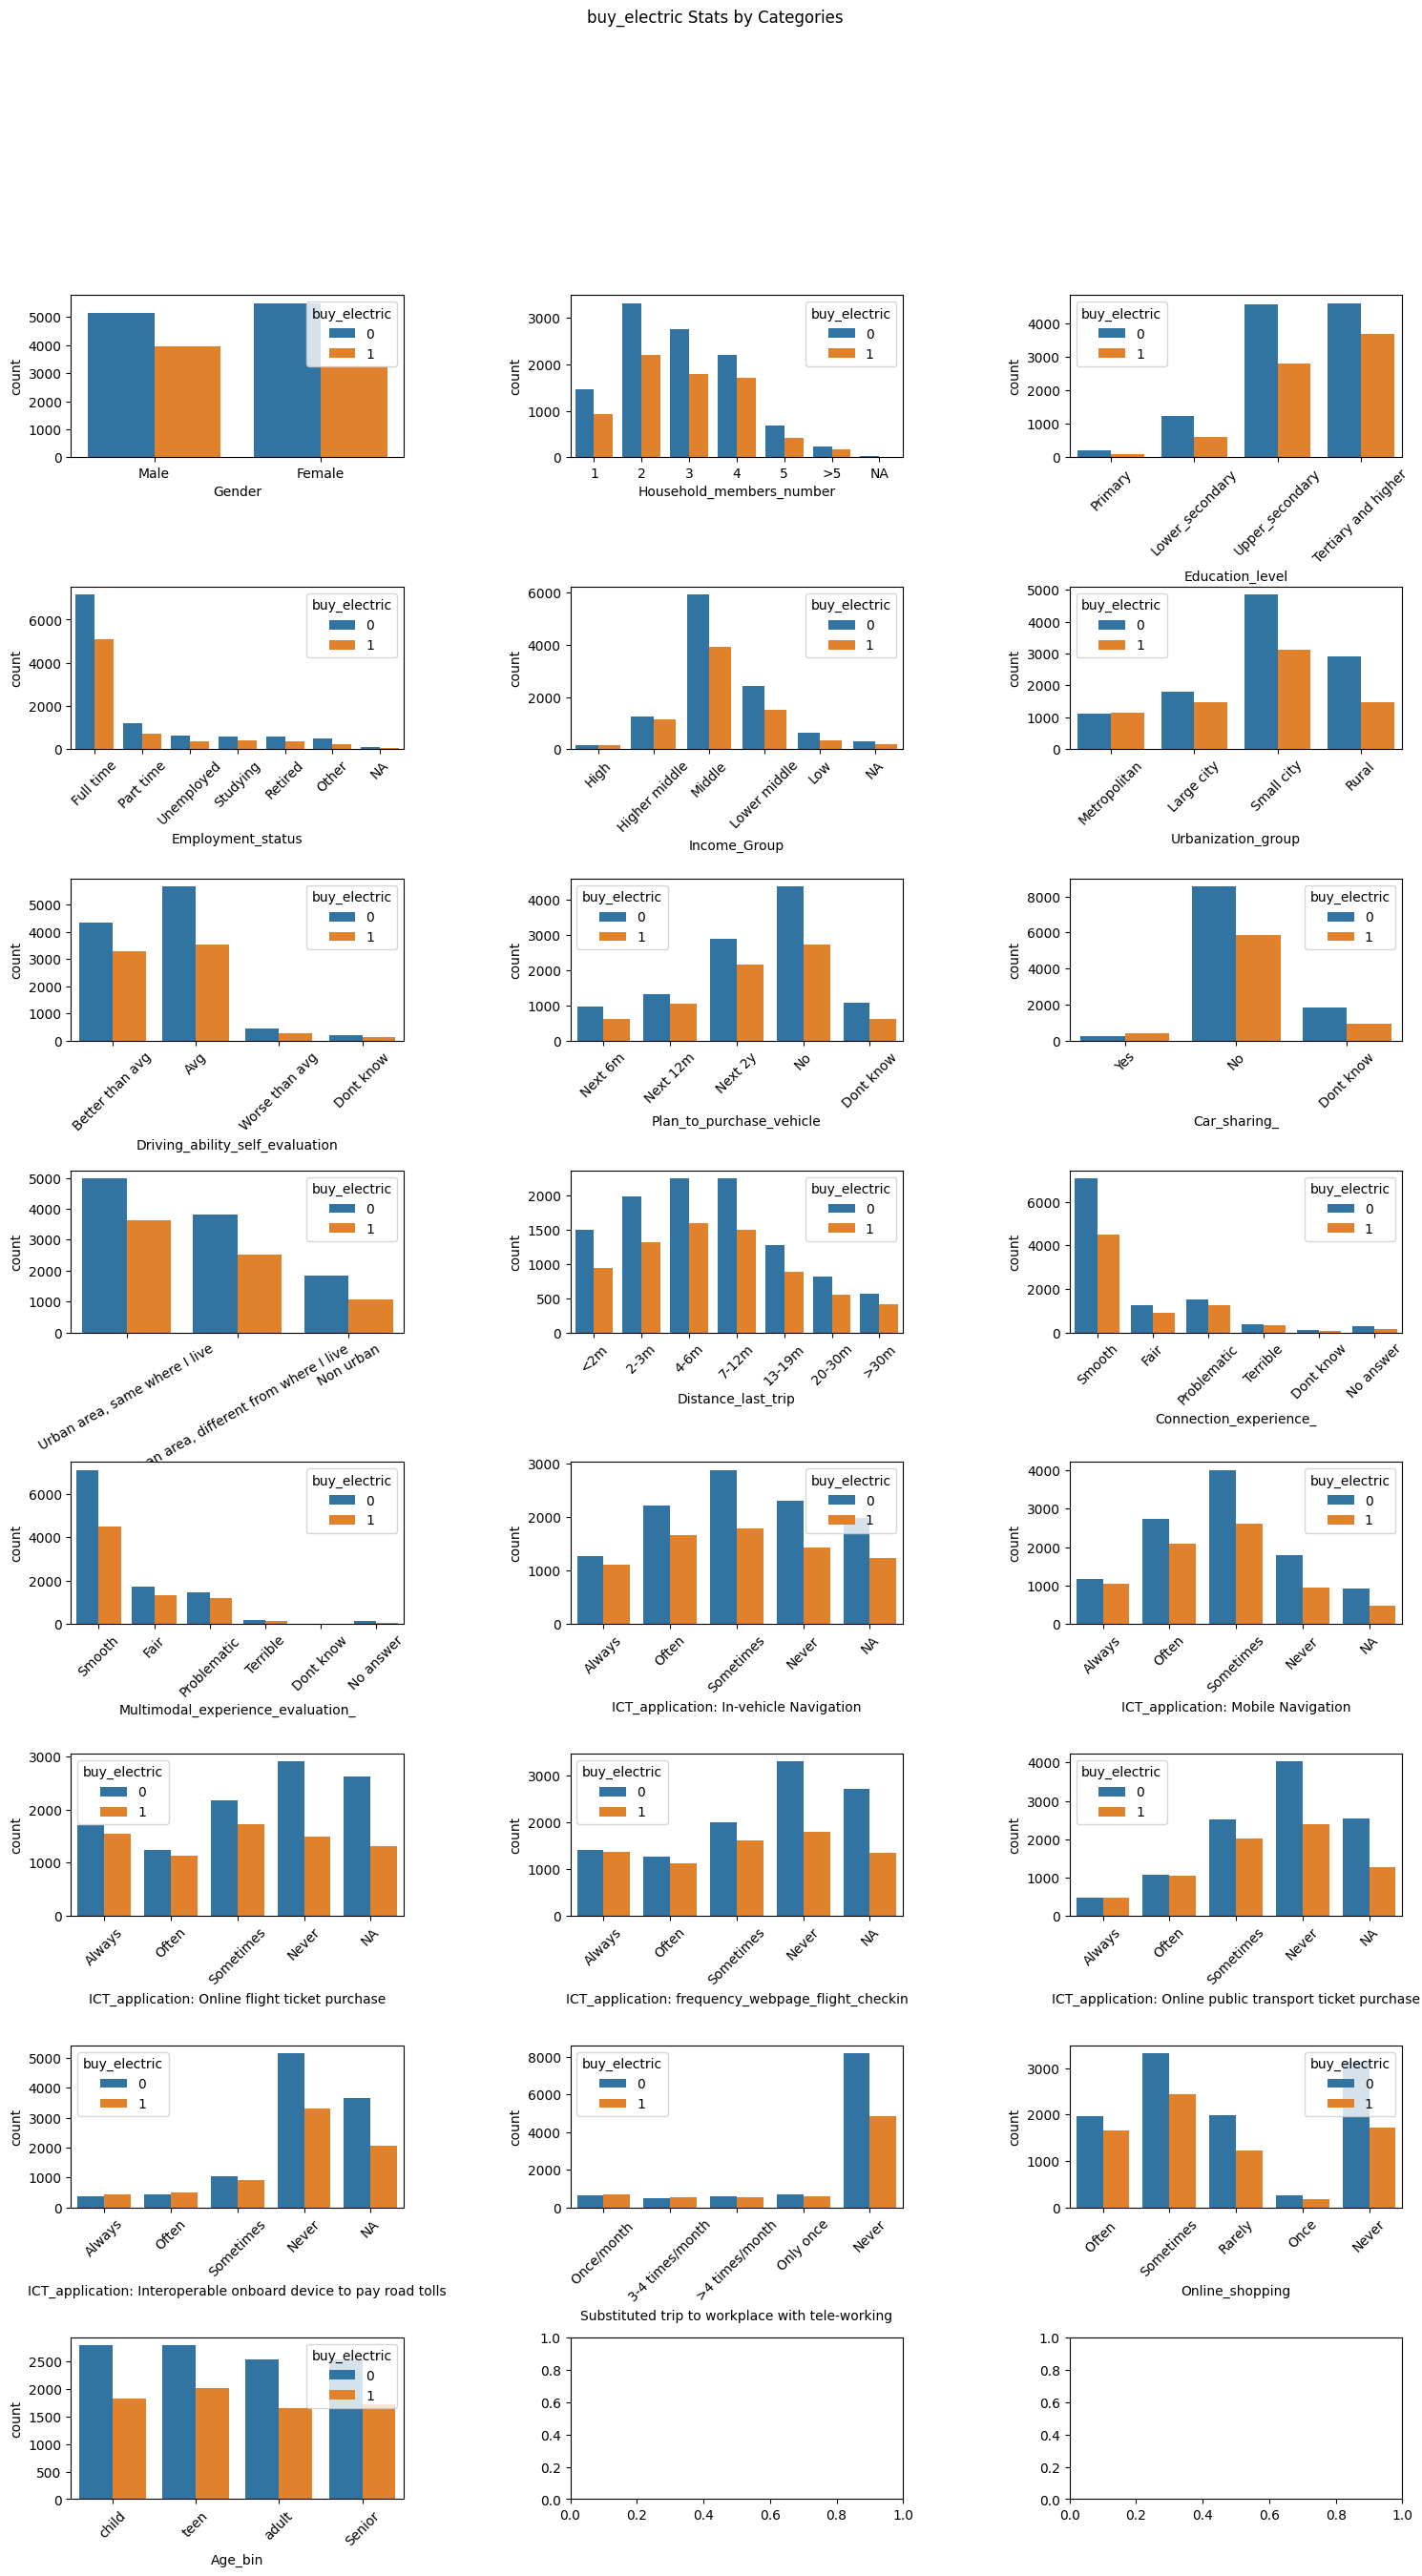

In [15]:
fig, axes = plt.subplots(8, 3, figsize=(18, 30))

fig.suptitle('buy_electric Stats by Categories')

sns.countplot(x='Gender', hue='buy_electric', data=df, ax=axes[0,0]).set(xlabel='Gender', xticklabels=['Male','Female'])
sns.countplot(x='Household_members_number', hue='buy_electric', data=df, ax=axes[0,1]).set(xlabel='Household_members_number', xticklabels=['1','2','3','4','5','>5','NA'])
sns.countplot(x='Education_level', hue='buy_electric', data=df, ax=axes[0,2]).set(xlabel='Education_level')
axes[0, 2].set_xticklabels(['Primary', 'Lower_secondary', 'Upper_secondary', 'Tertiary and higher'], rotation=45)
sns.countplot(x='Employment_status', hue='buy_electric', data=df, ax=axes[1,0]).set(xlabel='Employment_status')
axes[1, 0].set_xticklabels(['Full time','Part time','Unemployed','Studying','Retired','Other','NA'], rotation=45)
sns.countplot(x='Income_group', hue='buy_electric', data=df, ax=axes[1,1]).set(xlabel='Income_Group')
axes[1,1].set_xticklabels(['High','Higher middle','Middle','Lower middle','Low','NA'], rotation=45)
sns.countplot(x='Urbanization_group', hue='buy_electric', data=df, ax=axes[1,2]).set(xlabel='Urbanization_group')
axes[1,2].set_xticklabels(['Metropolitan','Large city','Small city','Rural'],rotation=45)
#sns.countplot(x='Centre_Suburbs', hue='buy_electric', data=df, ax=axes[2,0]).set(xlabel='Centre_Suburbs', xticklabels=['center of city','Suburbs'])
sns.countplot(x='Driving_ability_self_evaluation', hue='buy_electric', data=df, ax=axes[2,0]).set(xlabel='Driving_ability_self_evaluation')
axes[2,0].set_xticklabels(['Better than avg','Avg','Worse than avg','Dont know'],rotation=45)
sns.countplot(x='Plan_to_purchase_vehicle', hue='buy_electric', data=df, ax=axes[2,1]).set(xlabel='Plan_to_purchase_vehicle')
axes[2,1].set_xticklabels(['Next 6m','Next 12m','Next 2y','No','Dont know'],rotation=45)
sns.countplot(x='Car_sharing_', hue='buy_electric', data=df, ax=axes[2,2]).set(xlabel='Car_sharing_')
axes[2,2].set_xticklabels(['Yes','No','Dont know'],rotation=45)
sns.countplot(x='Urban_frequent_destination_', hue='buy_electric', data=df, ax=axes[3,0]).set(xlabel='Urban_frequent_destination_')
axes[3,0].set_xticklabels(['Urban area, same where I live','Urban area, different from where I live','Non urban'],rotation=30)
sns.countplot(x='Distance_last_trip', hue='buy_electric', data=df, ax=axes[3,1]).set(xlabel='Distance_last_trip')
axes[3,1].set_xticklabels(['<2m','2-3m', '4-6m','7-12m', '13-19m','20-30m','>30m'],rotation=45)
sns.countplot(x='Connection_experience_', hue='buy_electric', data=df, ax=axes[3,2]).set(xlabel='Connection_experience_')
axes[3,2].set_xticklabels(['Smooth','Fair', 'Problematic','Terrible', 'Dont know','No answer'],rotation=45)
sns.countplot(x='Multimodal_experience_evaluation_', hue='buy_electric', data=df, ax=axes[4,0]).set(xlabel='Multimodal_experience_evaluation_')
axes[4,0].set_xticklabels(['Smooth','Fair', 'Problematic','Terrible', 'Dont know','No answer'],rotation=45)

sns.countplot(x='ICT_application_use_1_', hue='buy_electric', data=df, ax=axes[4,1]).set(xlabel='ICT_application: In-vehicle Navigation')
axes[4,1].set_xticklabels(['Always','Often', 'Sometimes','Never', 'NA'],rotation=45)
sns.countplot(x='ICT_application_use_2_', hue='buy_electric', data=df, ax=axes[4,2]).set(xlabel='ICT_application: Mobile Navigation')
axes[4,2].set_xticklabels(['Always','Often', 'Sometimes','Never', 'NA'],rotation=45)
sns.countplot(x='ICT_application_use_3_', hue='buy_electric', data=df, ax=axes[5,0]).set(xlabel='ICT_application: Online flight ticket purchase')
axes[5,0].set_xticklabels(['Always','Often', 'Sometimes','Never', 'NA'],rotation=45)
sns.countplot(x='frequency_webpage_flight_checkin', hue='buy_electric', data=df, ax=axes[5,1]).set(xlabel='ICT_application: frequency_webpage_flight_checkin')
axes[5,1].set_xticklabels(['Always','Often', 'Sometimes','Never', 'NA'],rotation=45)
sns.countplot(x='ICT_application_use_7_', hue='buy_electric', data=df, ax=axes[5,2]).set(xlabel='ICT_application: Online public transport ticket purchase')
axes[5,2].set_xticklabels(['Always','Often', 'Sometimes','Never', 'NA'],rotation=45)
sns.countplot(x='ICT_application_use_10_', hue='buy_electric', data=df, ax=axes[6,0]).set(xlabel='ICT_application: Interoperable onboard device to pay road tolls')
axes[6,0].set_xticklabels(['Always','Often', 'Sometimes','Never', 'NA'],rotation=45)
sns.countplot(x='Teleworking', hue='buy_electric', data=df, ax=axes[6,1]).set(xlabel='Substituted trip to workplace with tele-working')
axes[6,1].set_xticklabels(['Once/month ','3-4 times/month', '>4 times/month','Only once', 'Never'],rotation=45)
sns.countplot(x='Online_shopping', hue='buy_electric', data=df, ax=axes[6,2]).set(xlabel='Online_shopping')
axes[6,2].set_xticklabels(['Often ','Sometimes', 'Rarely','Once', 'Never'],rotation=45)
sns.countplot(x='Age_bin', hue='buy_electric', data=df, ax=axes[7,0]).set(xlabel='Age_bin')
axes[7,0].set_xticklabels(["child", "teen", "adult", "Senior"],rotation=45)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.8)

# Show the plot
plt.show()

In [16]:
# Rank countries by preference to buy EVs- {Need to name these countries}

response_pct = df.groupby('Country')['buy_electric'].mean() * 100
response_pct.sort_values(ascending=False)

Country
27    60.183968
16    59.395532
23    52.162162
13    50.879397
18    50.733138
1     48.043185
28    47.689769
14    46.046512
4     42.705570
11    42.141864
3     40.664557
15    40.428790
9     40.199336
20    39.769452
12    39.589041
5     39.226519
26    39.223058
17    36.909091
24    36.088710
7     34.264432
2     32.859400
21    32.382311
10    31.294452
19    30.379747
22    30.058939
25    26.530612
8     24.920635
6     17.118402
Name: buy_electric, dtype: float64

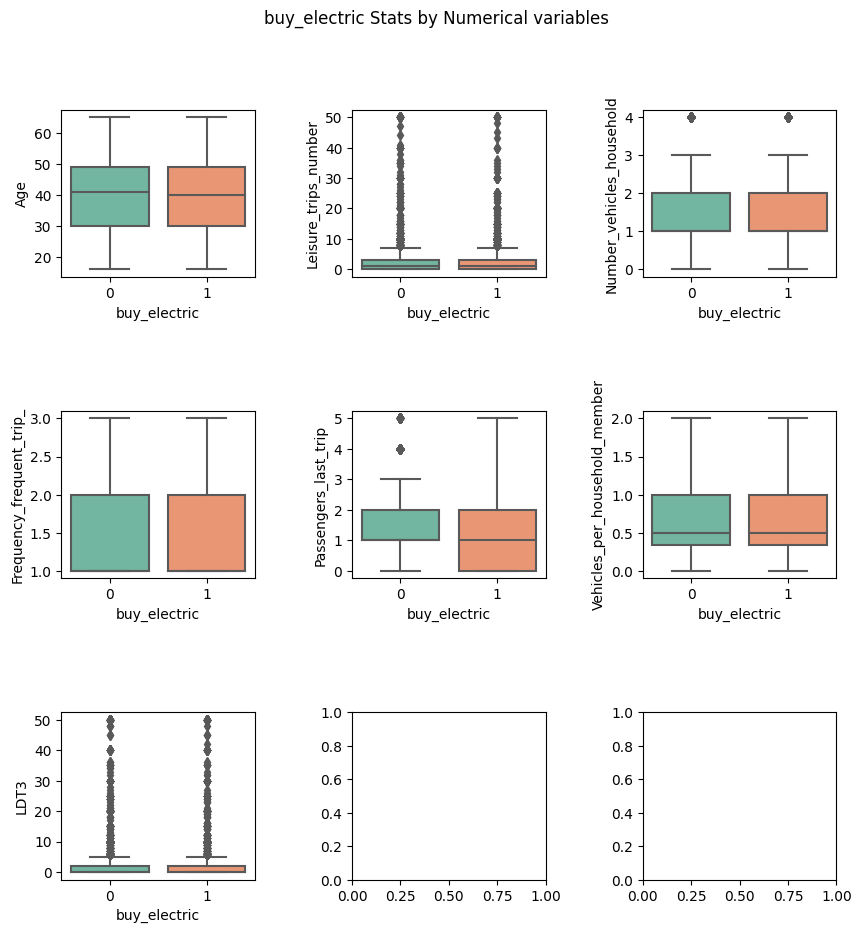

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

fig.suptitle('buy_electric Stats by Numerical variables')
sns.set_palette('Set2')


# Create box plots of age, grouped by target
sns.boxplot(data=df, x='buy_electric', y='Age',ax=axes[0,0])
sns.boxplot(data=df, x='buy_electric', y='Leisure_trips_number',ax=axes[0,1])
sns.boxplot(data=df, x='buy_electric', y='Number_vehicles_household',ax=axes[0,2])
sns.boxplot(data=df, x='buy_electric', y='Frequency_frequent_trip_',ax=axes[1,0])
sns.boxplot(data=df, x='buy_electric', y='Passengers_last_trip',ax=axes[1,1])
sns.boxplot(data=df, x='buy_electric', y='Vehicles_per_household_member',ax=axes[1,2])
sns.boxplot(data=df, x='buy_electric', y='LDT3',ax=axes[2,0])

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.8)

# Show the plot
plt.show()

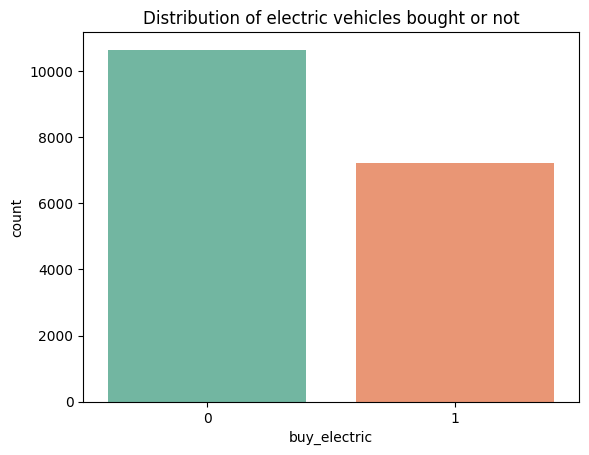

In [18]:
# Create a countplot of the target variable
sns.countplot(x='buy_electric', data=df)
plt.title('Distribution of electric vehicles bought or not')
plt.show()

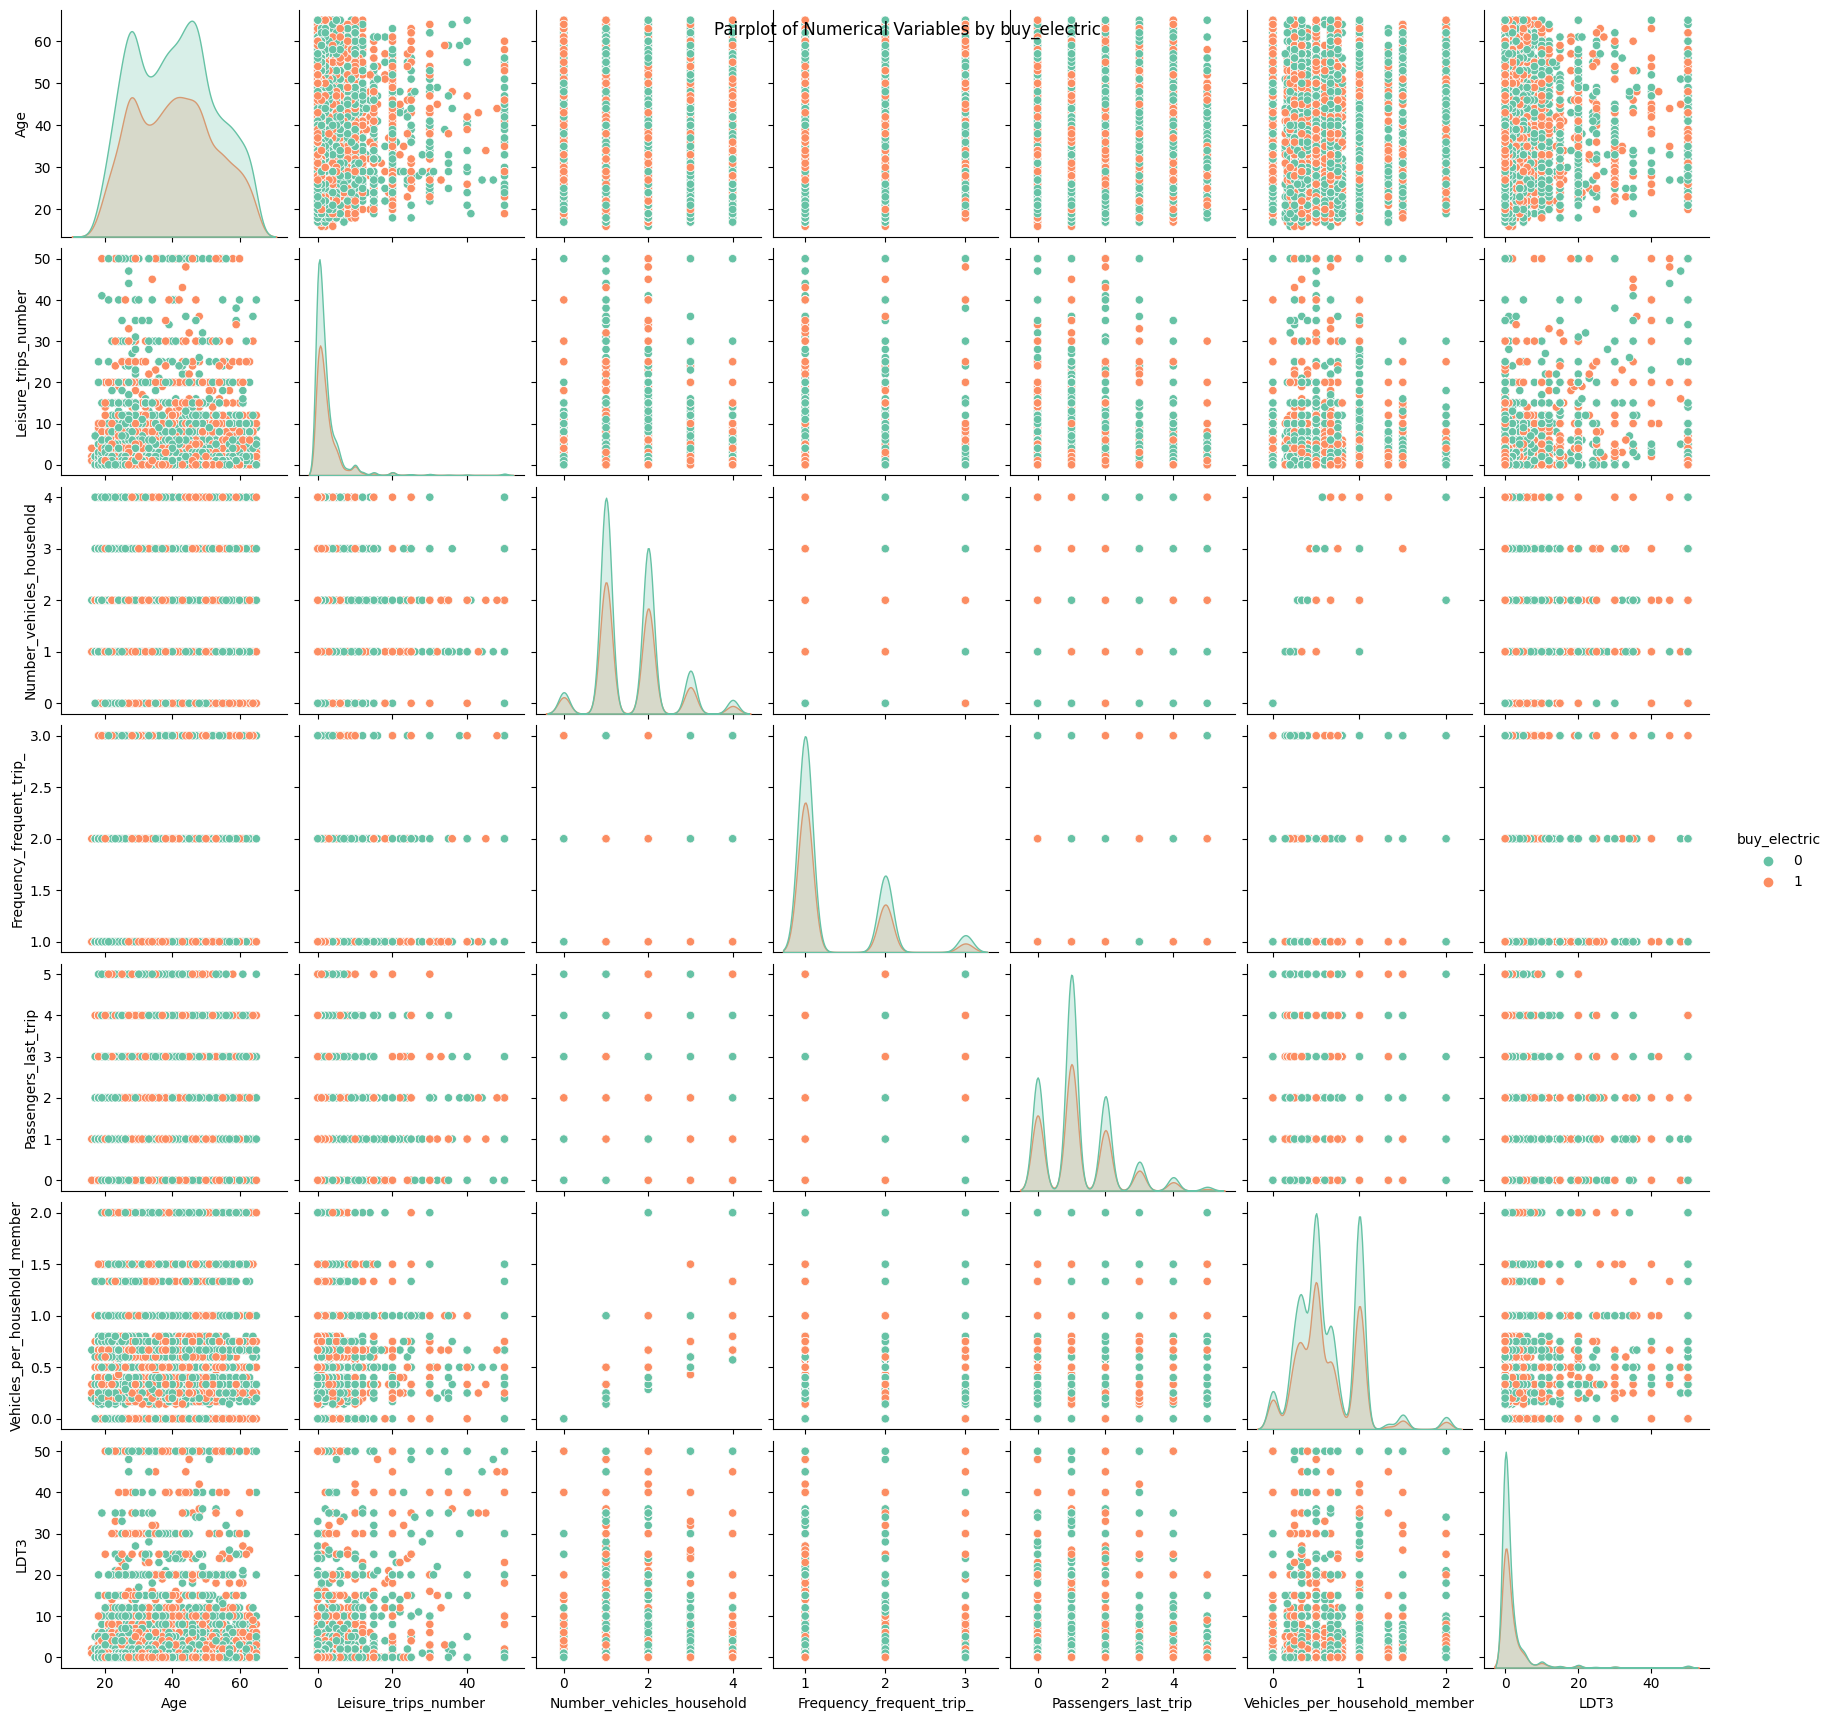

In [19]:
# Create a pairplot of the numerical variables against the target variable
sns.pairplot(df, vars=numeric_cols, hue='buy_electric')
plt.suptitle('Pairplot of Numerical Variables by buy_electric')
plt.show()